# An introduction to PanelSplit

In this introduction, we see how PanelSplit's cross-validation abilities can be used for imputation, hyper-parameter tuning, and prediction.

Let's import some panel data on countries using the World Bank API:

In [5]:
import wbdata # may need to install using !pip install wbdata
import pandas as pd

# Define indicators and countries of interest
indicators = {"NY.GDP.MKTP.CD": "GDP",  # Gross Domestic Product (current US$)
              "SP.POP.TOTL": "Population",  # Total population
              "FP.CPI.TOTL.ZG": "Inflation",     # Inflation, consumer prices (annual %)
              "GC.XPN.TOTL.CN": "Gov_Expenditure",  # Government expenditure (% of GDP)
              "NE.TRD.GNFS.ZS": "Trade_Balance"}    # Trade balance (% of GDP)

countries = ["USA", "GBR", "FRA", "DEU"]  # Example countries: USA, UK, France, Germany

# Fetch data from the World Bank API
panel_data = wbdata.get_dataframe(indicators, country=countries).reset_index()
panel_data['date'] = panel_data.date.astype(int)
panel_data = panel_data.query('date > 2000')

panel_data.head()

,country,date,GDP,Population,Inflation,Gov_Expenditure,Trade_Balance
0,Germany,2022,4.082469e+12,83797985.0,6.872574,NaN,99.880340
1,Germany,2021,4.278504e+12,83196078.0,3.066667,1.205354e+12,89.161094
2,Germany,2020,3.887727e+12,83160871.0,0.144878,1.109810e+12,81.147359
3,Germany,2019,3.889178e+12,83092962.0,1.445660,9.859610e+11,88.318389
4,Germany,2018,3.974443e+12,82905782.0,1.732169,9.397050e+11,88.519871


It appears there are missing rows. Let's see how many per column:

In [6]:
print(panel_data.isna().sum(axis=0))

panel_data[panel_data.isna().any(axis=1)]

country            0
date               0
GDP                0
Population         0
Inflation          0
Gov_Expenditure    3
Trade_Balance      1
dtype: int64


,country,date,GDP,Population,Inflation,Gov_Expenditure,Trade_Balance
0,Germany,2022,4.082469e+12,83797985.0,6.872574,NaN,99.880340
63,France,2022,2.779092e+12,67971311.0,5.222367,NaN,73.249853
126,United Kingdom,2022,3.089073e+12,66971395.0,7.922049,NaN,69.255797
189,United States,2022,2.543970e+13,333287557.0,8.002800,6.306213e+12,NaN


It apperas we don't have data for 2022 yet. Let's use PanelSplit to impute data, fitting on the training set and then transforming on the test set.

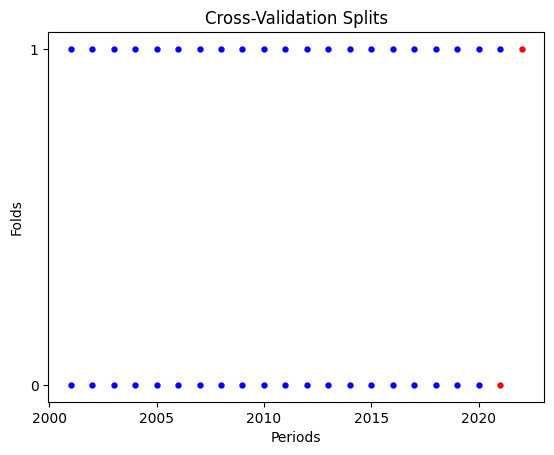

In [8]:
from panelsplit import PanelSplit

# Because we only need to impute 2022, we set the n_splits to the minimum allowed value, 2.
panel_split = PanelSplit(panel_data.date, n_splits = 2, test_size=1, plot=True)

- The graph is a helpful visualization to understand what this particular instance of PanelSplit is doing.
- By reading this graph, we see that there are 2 folds or splits. The first one (Fold 0) goes from 2001 - 2020 in the train set (blue) and then has a test set in 2021 (red).


When we perform imputation in the cell below, PanelSplit's cross_val_transform function iteratively goes through each split, fitting on the train set and then transforming the test set.

In [3]:
from sklearn.impute import KNNImputer

panel_data_imputed = panel_data.copy()
panel_data_imputed[features] = panel_split.cross_val_transform(KNNImputer(), panel_data[features])

NameError: name 'panel_split' is not defined

Now that we've imputed our data, let's do some hyper-parameter tuning. 

For this assessment, we want a a larger n_splits. Also, let's say that our validation set is 2010-2015 and our test set is 2016 onwards.

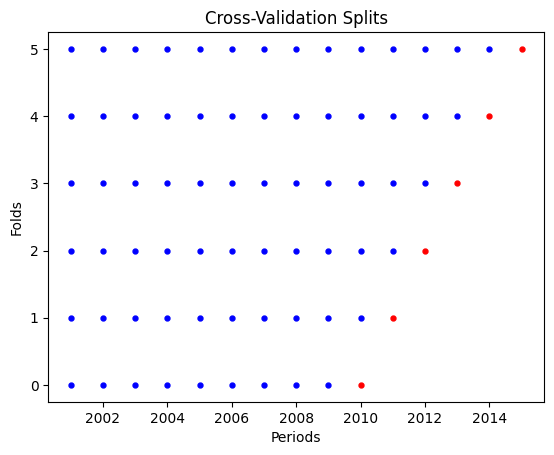

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

hyper_params = {'max_depth':[4,5]}
validation = panel_data_imputed.query('date < 2016')
panel_split = PanelSplit(validation.date, n_splits=6, test_size=1, plot=True)

grid_search = GridSearchCV(RandomForestRegressor(), param_grid = hyper_params, cv=panel_split)

grid_search.fit(validation[features], validation[target])

best_params = grid_search.best_params_

Great, we've found a set of hyper-parameters that work! Now let's predict on the test set from 2016 onwards, and then assess performance.

In [26]:
panel_split = PanelSplit(panel_data_imputed.date, n_splits = 7, test_size=1)
predictions = panel_split.cross_val_predict(RandomForestRegressor(**best_params), panel_data_imputed[features], panel_data_imputed[target], panel_data_imputed[['country','date']])

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00,  9.44it/s]


In [33]:
from sklearn.metrics import mean_absolute_percentage_error
results = panel_data_imputed.merge(predictions, how='left', on=['date','country']).query('date > 2015')
print(f'Test set MAPE: {round(mean_absolute_percentage_error(results.GDP, results.GDP_pred), 3)}')

Test set MAPE: 0.074
